In [19]:
import importlib
import model.gin

importlib.reload(model.gin)


<module 'model.gin' from '/Users/admin/Documents/Screenshots/LORE/model/gin.py'>

In [1]:
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader

In [2]:
dataset = TUDataset(root="TUDataset", name="MUTAG")

In [240]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

def visualize_mutag_graph(x, edge_index, pos=None, y=None, ax=None, title=None, save_path=None):
    
    G = nx.Graph()
    edge_list = edge_index.t().tolist()
    G.add_edges_from(edge_list)

    atom_types = ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br']

    node_labels = {}
    node_colors = []
    for i, feat in enumerate(x):
        atom_idx = feat.argmax().item()
        atom = atom_types[atom_idx]
        node_labels[i] = f"{i}_{atom}"
        if atom == 'C':
            node_colors.append('#FDB813') 
        elif atom == 'N':
            node_colors.append('#3776AB')  
        elif atom == 'O':
            node_colors.append('#FF6961') 
        else:
            node_colors.append('#ADD8E6') 


    nodes = list(G.nodes())

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    if pos is None:
        pos = nx.spring_layout(G, seed=42, iterations=50)
    nx.draw(
        G,
        pos=pos,
        node_size=400,
        font_size=9,
        node_color=[node_colors[i] for i in nodes],
        nodelist=nodes,
        font_weight='bold',
        ax=ax
    )
    for node in nodes:
        label = node_labels[node]
        x_pos, y_pos = pos[node]
        ax.text(x_pos, y_pos, label, fontsize=8, ha='center', va='center', color='black', fontweight='bold')

    if title:
        ax.set_title(title, fontsize=10, color = 'black')
    ax.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from torch_geometric.data import DataLoader
labels = [data.y.item() for data in dataset]

train_idx, temp_idx = train_test_split(
    list(range(len(dataset))),
    test_size=0.2,              
    stratify=labels,
    random_state=42
)


val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,              
    stratify=[labels[i] for i in temp_idx],
    random_state=42
)

train_dataset = [dataset[i] for i in train_idx]
val_dataset = [dataset[i] for i in val_idx]
test_dataset = [dataset[i] for i in test_idx]

print(f"Training set   = {len(train_dataset)} graphs")
print(f"Validation set = {len(val_dataset)} graphs")
print(f"Test set       = {len(test_dataset)} graphs")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Training set   = 150 graphs
Validation set = 19 graphs
Test set       = 19 graphs


/Users/admin/Documents/Screenshots/LORE/.env/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.path.dirname('model'), ".."))
sys.path.append(project_root)

In [6]:
import torch
from torch_geometric.data import DataLoader
from model.gin import GIN
from model.gcn import GCN
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
gin = GIN(
        in_channels=dataset.num_features,
        hidden_channels=32,
        out_channels=dataset.num_classes,
        num_layers=5,
    ).to(device)

gcn = GCN(
num_features=dataset.num_features, num_classes=2, dim=32)


In [11]:
import time
from model.gin import train, test
times = []
optimizer = torch.optim.Adam(gin.parameters(), lr=0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for epoch in range(0, 200):
    start = time.time()
    loss = train(gin, train_loader, optimizer, device)
    train_acc = test(gin, train_loader, device)
    test_acc = test(gin, test_loader, device)
    times.append(time.time() - start)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Test: {test_acc:.4f}')
print(f'Median time per epoch: {torch.tensor(times).median():.4f}s')

Epoch: 000, Loss: 0.5923, Train: 0.6800, Test: 0.6316
Epoch: 001, Loss: 0.4281, Train: 0.8733, Test: 0.8947
Epoch: 002, Loss: 0.3312, Train: 0.4000, Test: 0.4737
Epoch: 003, Loss: 0.3154, Train: 0.3800, Test: 0.4737
Epoch: 004, Loss: 0.3470, Train: 0.4867, Test: 0.5789
Epoch: 005, Loss: 0.3048, Train: 0.7400, Test: 0.7368
Epoch: 006, Loss: 0.3102, Train: 0.7867, Test: 0.7368
Epoch: 007, Loss: 0.2538, Train: 0.8467, Test: 0.7895
Epoch: 008, Loss: 0.2333, Train: 0.9133, Test: 0.7895
Epoch: 009, Loss: 0.1712, Train: 0.9467, Test: 0.7895
Epoch: 010, Loss: 0.2117, Train: 0.9400, Test: 0.7895
Epoch: 011, Loss: 0.1683, Train: 0.8200, Test: 0.7895
Epoch: 012, Loss: 0.1503, Train: 0.8467, Test: 0.7368
Epoch: 013, Loss: 0.2247, Train: 0.9000, Test: 0.6842
Epoch: 014, Loss: 0.2694, Train: 0.9400, Test: 0.7368
Epoch: 015, Loss: 0.1790, Train: 0.9200, Test: 0.7895
Epoch: 016, Loss: 0.1638, Train: 0.9467, Test: 0.7895
Epoch: 017, Loss: 0.1768, Train: 0.9733, Test: 0.7368
Epoch: 018, Loss: 0.2230, Tr

In [7]:
def evaluate_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.num_graphs

    return correct / total
train_acc = evaluate_accuracy(train_loader, gin, device)
val_acc = evaluate_accuracy(val_loader, gin, device)
test_acc = evaluate_accuracy(test_loader, gin, device)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.6667
Validation Accuracy: 0.6842
Test Accuracy: 0.6316


In [14]:
torch.save(gin.state_dict(), "../model/GIN_mutag.pth")

In [8]:
gin.load_state_dict(torch.load(project_root + "/model/GIN_mutag.pth"))
gcn.load_state_dict(torch.load(project_root + "/model/GCN_mutag.pth"))

<All keys matched successfully>

In [9]:
from model.gin import prepare_dataframe
from torch_geometric.data import Data
import torch.nn.functional as F
gin.eval()
gcn.eval()

GCN(
  (conv1): GraphConv(7, 32)
  (conv2): GraphConv(32, 32)
  (conv3): GraphConv(32, 32)
  (lin1): Linear(32, 32, bias=True)
  (lin2): Linear(32, 2, bias=True)
)

In [245]:
graph = dataset[6]
graph.x.shape
print(graph.y.item())
prob, embedding = model.predict(graph.x, graph.edge_index, None)
embedding = F.normalize(embedding, p = 2, dim=1)
embedding = torch.round(embedding * 1000) / 1000
embedding, prob.argmax(dim=1)

0


(tensor([[0.0460, 0.0400, 0.0180, 0.0500, 0.0780, 0.0600, 0.3060, 0.4090, 0.3840,
          0.3440, 0.1400, 0.3540, 0.0040, 0.2220, 0.0180, 0.0000, 0.0460, 0.3400,
          0.0120, 0.2190, 0.0210, 0.1100, 0.0220, 0.0680, 0.1030, 0.0190, 0.0330,
          0.0450, 0.0620, 0.2240, 0.0350, 0.1020]], grad_fn=<DivBackward0>),
 tensor([0]))

In [336]:
import random
def add_bidirectional_edges(edge_index):
    edge_set = set()
    unique_edges = []
    
    for i in range(edge_index.shape[1]):
        u, v = edge_index[:, i].tolist()
        edge = tuple(sorted((u, v)))
        
        if edge not in edge_set:
            edge_set.add(edge)
            unique_edges.append([u, v])

    bidirectional_edges = []
    for u, v in unique_edges:
        bidirectional_edges.append([u, v])
        bidirectional_edges.append([v, u])
    
    return torch.tensor(bidirectional_edges, dtype=torch.long).T
def is_connected(edge_index, num_nodes):
    g = nx.Graph()
    g.add_edges_from(edge_index.t().tolist())
    g.add_nodes_from(range(num_nodes))  
    return nx.is_connected(g)
class GraphGenome:
    def __init__(self, data):
        self.num_nodes = data.x.size(0)
        self.x = data.x.clone()
        self.edge_index = data.edge_index.clone().to(device)
        self.fitness = 0
        
    def to_data(self):
        return Data(x=self.x, edge_index=self.edge_index)
    
    def clone(self):
        return GraphGenome(Data(x=self.x.clone().to(device), edge_index=self.edge_index.clone().to(device)))
    
    def eval_fitness_sso(self, graphX, blackbox, distance_function, alpha1, alpha2):
        '''
        self: child
        embedding : graph embedding
        prob: xác suất cho từng class (đã qua softmax)
        '''
        prob_X, embedding_X = blackbox.predict(graphX.x, add_bidirectional_edges(graphX.edge_index), None)
        prob_G, embedding_G = blackbox.predict(self.x, add_bidirectional_edges(self.edge_index), None)
        
        uX = F.normalize(embedding_X, p=2, dim=1)
        uG = F.normalize(embedding_G, p=2, dim=1)
        # uX = F.softmax(embedding_X, dim=1)
        # uG = F.softmax(embedding_G, dim=1)
        
        distance = torch.norm(uX - uG, p=2).item() # kc euclide 
        if distance <=  1e-8:
            distance = 1
        #distance = 0 if prob_X.argmax().item() == prob_G.argmax().item() else 1
        
        print('distance sso: ', distance, ' ---- label: ', prob_G.argmax().item(), ' ---- prob: ', prob_G)
        return distance
    
    def eval_fitness_sdo(self, graphX, blackbox, distance_function, alpha1, alpha2, DO_graphs_embedding):
        '''
        self: child
        DO_graphs_embedding: list graph embedding của các graph không cùng class với graphX
        '''
        prob_G, embedding_G = blackbox.predict(self.x, add_bidirectional_edges(self.edge_index), None)
        # uG = F.softmax(embedding_G, dim=1)
        uG = F.normalize(embedding_G, p=2, dim=1)
        distances = []
        for embedding in DO_graphs_embedding:
            uX = embedding
            distance = torch.norm(uX - uG, p=2).item()
            #distance = 0 if prob_X.argmax().item() == prob_G.argmax().item() else 1
            distances.append(distance)
        
        distance = min(distances)
        print("Index of chosen graph", distances.index(distance))
        if distance <= 1e-8:
            distance = 1
            
        print('distance sdo: ', distance, ' ---- label: ', prob_G.argmax().item(), ' ---- prob: ', prob_G)
        return distance
    
    def mutate(self, graphX, blackbox, distance_function, alpha1, alpha2, case_type, DO_graphs):
        edge_list = set(map(tuple, self.edge_index.T.tolist()))
        num_nodes = self.num_nodes
        feature_dim = self.x.size(1)
        mutation_choices = ['add_edge', 'remove_edge', 'change_node', 'add_node', 'remove_node']
        mutation_probs = [0.2, 0.2, 0.2, 0.2, 0.2]  
        mutation_type = random.choices(mutation_choices, weights=mutation_probs, k=1)[0]
        new_x = self.x.clone()
        
        if mutation_type == 'add_edge':
            for _ in range(10):
                u, v = random.sample(range(num_nodes), 2)
                edge = (u, v) if u < v else (v, u)
                if edge not in edge_list:
                    edge_list.add(edge)
                    break

        elif mutation_type == 'remove_edge':
            if edge_list:
                edge = random.choice(list(edge_list))
                edge_list.remove(edge)
                
        elif mutation_type == 'add_node':
            new_node_x = torch.zeros_like(self.x[0])
            label_index = random.randint(0, feature_dim - 1)
            new_node_x[label_index] = 1
            new_x = torch.cat([new_x, new_node_x.unsqueeze(0)], dim=0)
            
            if edge_list:
                u = random.randint(0, num_nodes - 2)
                edge = (u, num_nodes - 1) if u < num_nodes - 1 else (num_nodes - 1, u)
                edge_list.add(edge)
                
        elif mutation_type == 'remove_node':
            index = random.randint(0, num_nodes - 1)
            new_x = torch.cat([new_x[:index], new_x[index + 1:]], dim=0)
            edge_list = {edge for edge in edge_list if index not in edge}
            edge_list = {(u - 1 if u > index else u, v - 1 if v > index else v) for u, v in edge_list}
            edge_list = set(tuple(edge) for edge in edge_list)
                
        else:
            index = random.randint(0, num_nodes - 1) # index node đổi label
            current_label = torch.argmax(new_x[index]).item()
            
            new_label = random.choice([j for j in range(new_x.size(1)) if j != current_label])
            new_x[index] = torch.zeros_like(new_x[index])
            new_x[index][new_label] = 1
        
        
        if len(list(edge_list)) < 1 or new_x.size(0) < 1:
            return self
        
        new_edge_index = torch.tensor(list(edge_list), dtype=torch.long).T
        mutated_graph = GraphGenome(Data(x=new_x, edge_index=new_edge_index))
        
        if is_connected(mutated_graph.edge_index, mutated_graph.x.size(0)) == False:
            return self
        
        if case_type == 'sso':
            mutated_graph.fitness = mutated_graph.eval_fitness_sso(graphX, blackbox, distance_function, alpha1, alpha2)
        else:
            mutated_graph.fitness = mutated_graph.eval_fitness_sdo(graphX, blackbox, distance_function, alpha1, alpha2, DO_graphs)
        
        return mutated_graph
    
    def crossover(self, other, graphX, blackbox, distance_function, alpha1, alpha2, case_type, DO_graphs):
        parent1_edges = [tuple(edge.tolist()) for edge in self.edge_index.T]
        parent2_edges = [tuple(edge.tolist()) for edge in other.edge_index.T]
        parent1_edges = list(set(parent1_edges))
        parent2_edges = list(set(parent2_edges))
        feature_dim = self.x.size(1)
        
        if len(parent1_edges) < 2 or len(parent2_edges) < 2:
            return self  

        parent_size = min(len(parent1_edges), len(parent2_edges))
        cut1, cut2 = sorted(random.sample(range(parent_size), 2))
        child_edges = parent1_edges[:cut1] + parent2_edges[cut1:cut2] + parent1_edges[cut2:]
        child_edges = list(set(child_edges)) 
        
        all_node = sorted(set([u for u, v in child_edges] + [v for u, v in child_edges] + list(range(self.num_nodes))))
        new_node_map = {
            node: id
            for id, node in enumerate(all_node)
        }

        remapped_edges = [(new_node_map[u], new_node_map[v]) for u, v in child_edges]
        new_edge_index = torch.tensor(remapped_edges, dtype=torch.long).T

        new_x = torch.zeros((len(all_node), feature_dim))

        for old_id, new_id in new_node_map.items(): 
            if old_id < self.num_nodes:
                new_x[new_id] = self.x[old_id]
            elif old_id < other.num_nodes:
                new_x[new_id] = other.x[old_id]
            else:
                new_x[new_id] = torch.randn(feature_dim) 
        
        child = GraphGenome(Data(x=new_x, edge_index=new_edge_index))
        
        if is_connected(child.edge_index, child.x.size(0)) == False:
            return self
        
        if case_type == 'sso':
            child.fitness = child.eval_fitness_sso(graphX, blackbox, distance_function, alpha1, alpha2)
        else:
            child.fitness = child.eval_fitness_sdo(graphX, blackbox, distance_function, alpha1, alpha2, DO_graphs)

        return child



def initialize_population(size, graphX, blackbox, distance_function, alpha1, alpha2, case_type, DO_graphs):
    population = []
    for _ in range(size):
        individual = GraphGenome(graphX).mutate(graphX, blackbox, distance_function, alpha1, alpha2, case_type, DO_graphs)
        population.append(individual)
    # population = [GraphGenome(graphX.clone()) for _ in range(size)]
    
    for individual in population:
        if case_type == 'sso':
            individual.fitness = individual.eval_fitness_sso(graphX, blackbox, distance_function, alpha1, alpha2)
        else:
            individual.fitness = individual.eval_fitness_sdo(graphX, blackbox, distance_function, alpha1, alpha2, DO_graphs)

            
    return population

def select_parents(population, ratio):
    unique_fitness = {}
    for individual in population:
        if individual.fitness not in unique_fitness:
            unique_fitness[individual.fitness] = individual
    
    distinct_population = list(unique_fitness.values())
    distinct_population.sort(key=lambda individual: individual.fitness)
    
    return distinct_population[:int(ratio * len(distinct_population))]

def get_graphs_DO_embedding(label, dataset, blackbox):
    DO_graphs_embedding = []
    for i in range(len(dataset)):
        if dataset[i].y != label:
            prob_X, embedding_X = blackbox.predict(dataset[i].x, dataset[i].edge_index, None)
        
            # uX = F.softmax(embedding_X, dim=1)
            uX = F.normalize(embedding_X, p=2, dim=1)
            DO_graphs_embedding.append(uX)
    return DO_graphs_embedding

def genetic_algorithm(graphX, populationSize, generations, blackbox, distance_function, alpha1, alpha2):
    case_population_size = populationSize // 2
    case_type = ['sso', 'sdo']
    populations = {}
    DO_graphs_embedding = get_graphs_DO_embedding(graphX.y, dataset, blackbox)
        
    for type in case_type:
        populations[type] = initialize_population(
                    case_population_size, graphX, blackbox, distance_function, alpha1, alpha2, type, DO_graphs_embedding
                )
        
        
        for gen in range(generations):
            print(f"{type} : Generation {gen+1}/{generations} =====")
            new_population = []
            best_individuals = select_parents(populations[type], 0.1)
            new_population.extend(best_individuals[:len(best_individuals) // 2]) # di truyen qua the he sau
            fitness_set = set(ind.fitness for ind in new_population)
            while len(new_population) < case_population_size: #200
                parent1, parent2 = random.sample(best_individuals, 2)
                child = parent1.crossover(parent2, graphX, blackbox, distance_function, alpha1, alpha2, type, DO_graphs_embedding)
                child = child.mutate(graphX, blackbox, distance_function, alpha1, alpha2, type, DO_graphs_embedding)
                
                #child = child.mutate(graphX, blackbox, distance_function, alpha1, alpha2, type, DO_graphs_embedding)
                
                EPSILON = 1e-8  # kiểm tra gần đúng cho số thực
                if not any(abs(child.fitness - f) < EPSILON for f in fitness_set):
                    fitness_set.add(child.fitness)
                    new_population.append(child)
                    
            populations[type] = new_population
    
    return populations
    final_population = []
    for population in populations.values():
        final_population.extend(population)
        
    return final_population

In [337]:
from distance import *

graphX = dataset[0]
graphX.edge_index = remove_bidirectional_edge(graphX.edge_index)
model = gin
final_populations = genetic_algorithm(graphX=graphX, populationSize=800, generations=10, 
                                blackbox= model, distance_function=my_distance2, alpha1=0.5, alpha2 = 0.5)

distance sso:  0.7282905578613281  ---- label:  0  ---- prob:  tensor([[0.9419, 0.0581]], grad_fn=<SoftmaxBackward0>)
distance sso:  0.5643932819366455  ---- label:  0  ---- prob:  tensor([[0.8354, 0.1646]], grad_fn=<SoftmaxBackward0>)
distance sso:  0.23728656768798828  ---- label:  1  ---- prob:  tensor([[0.0512, 0.9488]], grad_fn=<SoftmaxBackward0>)
distance sso:  0.7960692644119263  ---- label:  0  ---- prob:  tensor([[0.9947, 0.0053]], grad_fn=<SoftmaxBackward0>)
distance sso:  0.7304874658584595  ---- label:  0  ---- prob:  tensor([[0.9908, 0.0092]], grad_fn=<SoftmaxBackward0>)
distance sso:  0.24102620780467987  ---- label:  1  ---- prob:  tensor([[3.6461e-05, 9.9996e-01]], grad_fn=<SoftmaxBackward0>)
distance sso:  0.7081910371780396  ---- label:  0  ---- prob:  tensor([[0.9755, 0.0245]], grad_fn=<SoftmaxBackward0>)
distance sso:  0.18979181349277496  ---- label:  1  ---- prob:  tensor([[5.0471e-06, 9.9999e-01]], grad_fn=<SoftmaxBackward0>)
distance sso:  0.4705236852169037  --

In [184]:
type = 'sdo'
population = sorted(final_populations[type], key=lambda x: x.fitness)

prob = model.predict(population[1].x, ensure_undirected(population[1].edge_index), None)

print(prob[0])

tensor([[2.2558e-04, 9.9977e-01]], grad_fn=<SoftmaxBackward0>)


143
Predicted class:  0


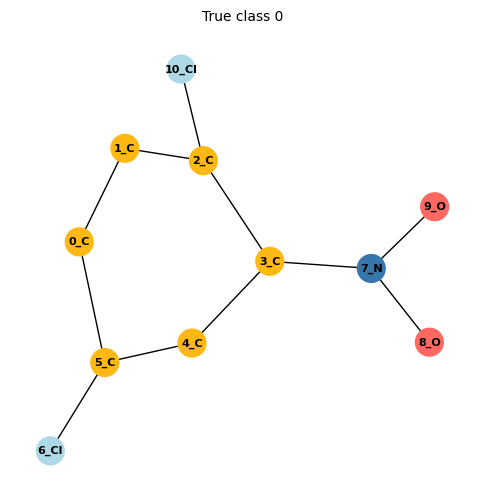

In [ ]:
count = 0
 
for i in range(len(dataset)):
        if dataset[i].y != graphX.y:
            if count == 48:
                graph_DO = dataset[i]
                print(i)
                break
            count += 1
title = f"True class {graph_DO.y.item()}"     
pred = model.predict(graph_DO.x, graph_DO.edge_index, None)
print("Predicted class: ", pred[0].argmax().item())

visualize_mutag_graph(graph_DO.x, graph_DO.edge_index, graph_DO.y, title=title)

In [ ]:
graph_1 = final_populations['sdo'][0]
prob, embedding = model.predict(graph_1.x, ensure_undirected(graph_1.edge_index), None, 1, True)
probDO, embedding_DO = model.predict(graph_DO.x, graph_DO.edge_index, None, 1, True)
embedding_DO = F.normalize(embedding_DO, p=2, dim=1)
embedding = F.normalize(embedding, p=2, dim=1)
distance = torch.norm(embedding - embedding_DO, p=2).item()
distance 

0.020196978002786636

### Test crossover ###

In [322]:
from distance import my_distance2
graph1 = dataset[2]
graph2 = dataset[3]

parent1 = GraphGenome(Data(x=graph1.x, edge_index=remove_bidirectional_edge(graph1.edge_index)))
parent2 = GraphGenome(Data(x=graph2.x, edge_index=remove_bidirectional_edge(graph2.edge_index)))

# Test crossover
child = parent1.crossover(
    other=parent2,
    graphX=graphX,
    blackbox=model,
    distance_function=my_distance2,
    alpha1=0.5,
    alpha2=0.5,
    case_type='sso',
    DO_graphs=None
)


distance sso:  1.3247054815292358  ---- label:  0  ---- prob:  tensor([[0.9371, 0.0629]], grad_fn=<SoftmaxBackward0>)


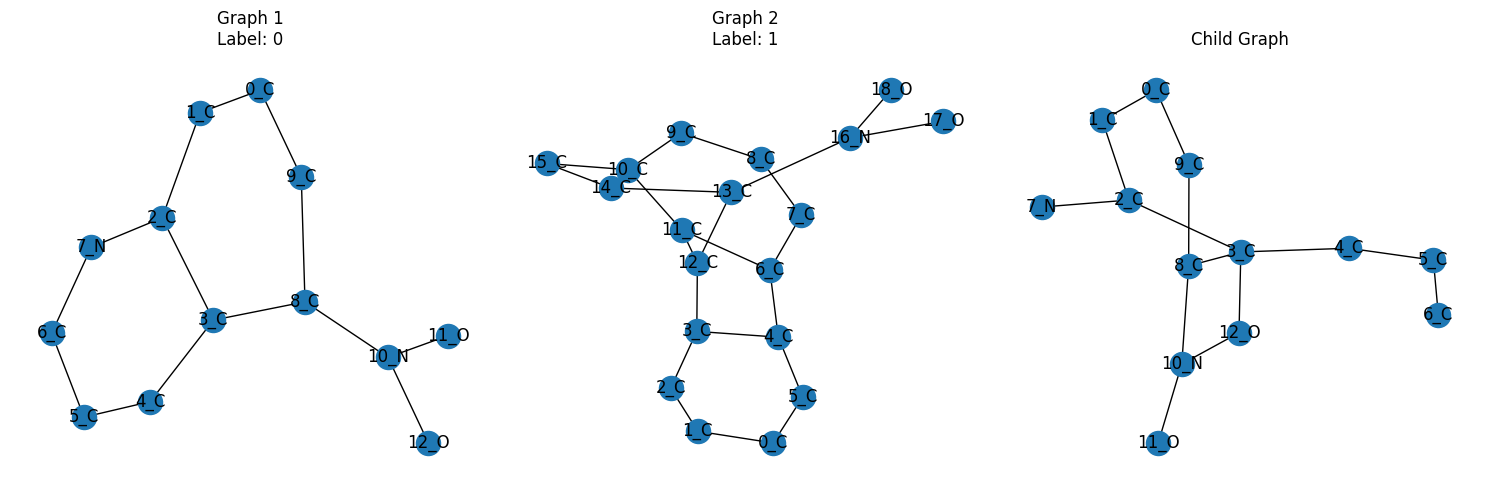

In [323]:
G1 = to_networkx(Data(x=parent1.x, edge_index=remove_bidirectional_edge(parent1.edge_index)), to_undirected=True)
G2 = to_networkx(Data(x=parent2.x, edge_index=remove_bidirectional_edge(parent2.edge_index)), to_undirected=True)
G_child = to_networkx(Data(x=child.x, edge_index=remove_bidirectional_edge(child.edge_index)), to_undirected=True)
pos1 = nx.spring_layout(G1)
pos2 = nx.spring_layout(G2)
pos_child = nx.spring_layout(G_child)
atom_types = ["C", "N", "O", "F", "I", "Cl", "Br"]
node_labels1 = {i: f"{i}_{atom_types[x.argmax().item()]}" for i, x in enumerate(graph1.x)}
node_labels2 = {i: f"{i}_{atom_types[x.argmax().item()]}" for i, x in enumerate(graph2.x)}
node_labels_child = {i: f"{i}_{atom_types[x.argmax().item()]}" for i, x in enumerate(child.x)} 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

nx.draw(G1, pos1, labels=node_labels1, ax=axes[0])
axes[0].set_title(f"Graph 1\nLabel: {graph1.y.item()}")

nx.draw(G2, pos2, labels=node_labels2, ax=axes[1])
axes[1].set_title(f"Graph 2\nLabel: {graph2.y.item()}")

nx.draw(G_child, pos_child, labels=node_labels_child, ax=axes[2])
axes[2].set_title("Child Graph")

plt.tight_layout()
plt.show()

### Visualize populations ###

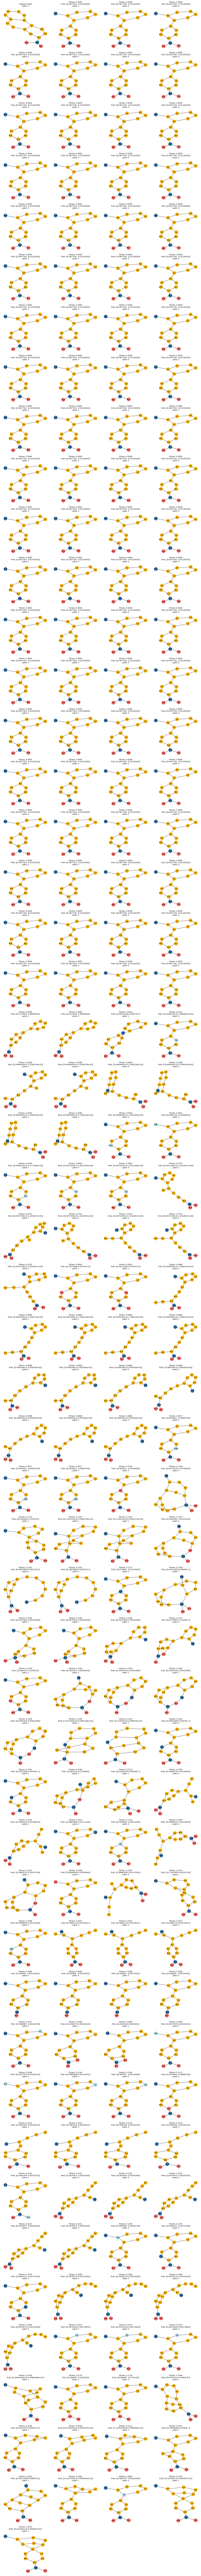

In [234]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import math
type = 'sdo'
population = sorted(final_populations[type], key=lambda x: x.fitness)

num_mutated = len(population)
total_graphs = num_mutated + 1
cols = 4
rows = math.ceil(total_graphs / cols)

def layout(G):
    return nx.spring_layout(G, seed=42)
G_original = to_networkx(graphX, to_undirected=True)
pos_original = layout(G_original)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()
graph_original = graphX
ori_label = graph_original.y.item()
visualize_mutag_graph(graph_original.x, graph_original.edge_index, ax=axes[0], title=f"Original Graph\nLabel: {ori_label}")

for i, individual in enumerate(population):
    graph_mutated = individual
    prob, embedding = model.predict(
        graph_mutated.x,
        ensure_undirected(graph_mutated.edge_index),
        None
    )
    prob = prob.detach().cpu().numpy()
    pred_label = prob.argmax().item()
    

    title = f"Fitness: {individual.fitness:.4f}\nProb: {prob}\nLabel: {pred_label}"
    visualize_mutag_graph(graph_mutated.x, graph_mutated.edge_index, y = None, ax=axes[i + 1], title=title)

for i in range(total_graphs, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [242]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx, remove_isolated_nodes, to_undirected
from torch_geometric.data import Data

def generate_population_dataframe(population, model, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    
    records = []
    
    for i, individual in enumerate(population):
        graph = to_networkx(individual.to_data(), to_undirected=True)
        
        img_path = os.path.join(save_dir, f"graph_{i}.png")
        visualize_mutag_graph(
            individual.x,
            individual.edge_index,
            y=None,
            ax=None,
            save_path=img_path,
        )
        
        with torch.no_grad():
            probs, graph_emb = model.predict(individual.x, add_bidirectional_edges(individual.edge_index), None)
            pred = probs.argmax().item()
            embedding = F.softmax(graph_emb, dim=-1).squeeze().cpu().numpy()
            embedding = embedding.tolist()
            embedding = [round(x, 4) for x in embedding]

        records.append({
            "img_path": img_path,
            "prediction": pred,
            "output": probs.squeeze().cpu().numpy().tolist(),
            "embedding": embedding,
            "fitness": getattr(individual, 'fitness', None)  # nếu có
        })

    return pd.DataFrame(records)


In [339]:
final_populations['sso'] = sorted(final_populations['sso'], key=lambda x: x.fitness)
final_populations['sdo'] = sorted(final_populations['sdo'], key=lambda x: x.fitness)
df_sso = generate_population_dataframe(final_populations['sso'], model, save_dir="visualization/mutag/population_sso")
df_sdo = generate_population_dataframe(final_populations['sdo'], model, save_dir="visualization/mutag/population_sdo")
df_sdo.to_csv("visualization/mutag/population_sdo.csv", index=False)
df_sso.to_csv("visualization/mutag/population_sso.csv", index=False)

img_path = os.path.join("visualization", f"graph_X.png")
visualize_mutag_graph(
    graphX.x,
    graphX.edge_index,
    y=None,
    ax=None,
    save_path=img_path,
)

In [340]:
def visualize(df, file_name):
    f = open(file_name, "wt", encoding='utf-8')
    f.write("<html>\n")
    f.write("<body>\n")
    f.write("<h2>Final population</h2>\n")
    f.write("<table border='1' cellspacing='0' cellpadding='10'>\n")
    f.write("<h2 style='text-align: center;'><img src='visualization/graph_X.png' width='300'></h2>")
    for i in range(df.shape[0]):
        row = df.iloc[i]
        img_path = row['img_path']
        pred = row['prediction']
        embedding = row['embedding']

        f.write("<tr>")
        f.write(f"<td><img src='{img_path}' width='300' height='300'></td>")
        f.write(f"<td><b>Prediction:</b> {pred}<br><b>Embedding:</b> [{embedding}]<br><b>Output:</b> {row['output']}</td>")
        f.write(f"<td><b>Distance:</b> {row['fitness']}</td>")
        f.write("</tr>\n")
    f.write("</table>\n")
    f.write("</body>\n")
    f.write("</html>\n")
    f.close()

visualize(df_sso, "mutag_population_sso.html")
visualize(df_sdo, "mutag_population_sdo.html")

### Analyze populations ###

In [334]:
import pandas as pd
import torch
import numpy as np
from model.gin import prepare_dataframe

population = final_populations['sso'] + final_populations['sdo']
df = prepare_dataframe(population, gin, device, ground_truth=False, only_edge=True, node_label=True)

df.head()

nL_0 nL_1 nL_2 nL_3 nL_4 nL_5 nL_6 nL_7 nL_8 nL_9  ... n13_n14 n13_n15  \
0    C    C    C    O    C    C    C    C    C    C  ...       0       0   
1    C    C    C    C    C    C    C    C    C    C  ...       0       0   
2    C    C    C    C    C    C    C    C    C    C  ...       0       0   
3    C    C    C    C    C    C    C    C    C    C  ...       1       1   
4    C    C    C    O    C    C    C    C    C    C  ...       0       0   

  n13_n16 n14_n14 n14_n15 n14_n16 n15_n15  n15_n16  n16_n16  y  
0       0       0       1       1       0        0        0  1  
1       0       0       1       1       0        0        0  1  
2       0       0       1       1       0        0        0  1  
3       0       0       0       0       0        0        0  1  
4       0       0       1       1       0        0        0  1  

[5 rows x 171 columns]

In [335]:
class_1 = df[df['y'] == 1].shape[0]
class_0 = df[df['y'] == 0].shape[0]
class_1, class_0

(517, 283)

17


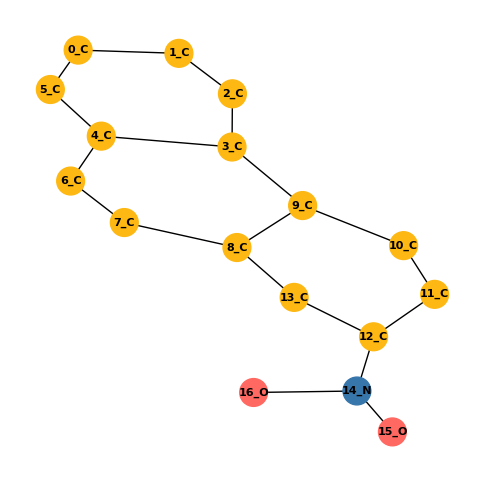

In [321]:
import pickle
# with open('../mutagX.pkl', 'rb') as f:
#     graphX = pickle.load(f)
    
graphX = dataset[0]
print(len(graphX.x))
visualize_mutag_graph(graphX.x, graphX.edge_index)

['blue', 'blue', 'green', 'blue', 'green', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'blue', 'green', 'blue', 'green', 'blue']


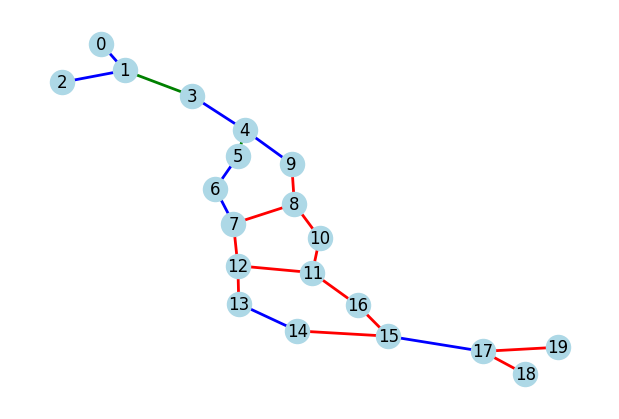

In [ ]:
data = dataset[7]
G = to_networkx(data, edge_attrs=['edge_attr'], to_undirected=True)

edge_attrs = data.edge_attr.argmax(dim=1).tolist() 

# Loai lien kết: 0: aromatic, 1: single, 2: double, 3: triple
edge_color_list = ['red', 'blue', 'green', 'grey']  
edge_colors = [edge_color_list[attr] for attr in edge_attrs]
print(edge_colors)

plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42) 
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color=edge_colors, width=2)

plt.show()

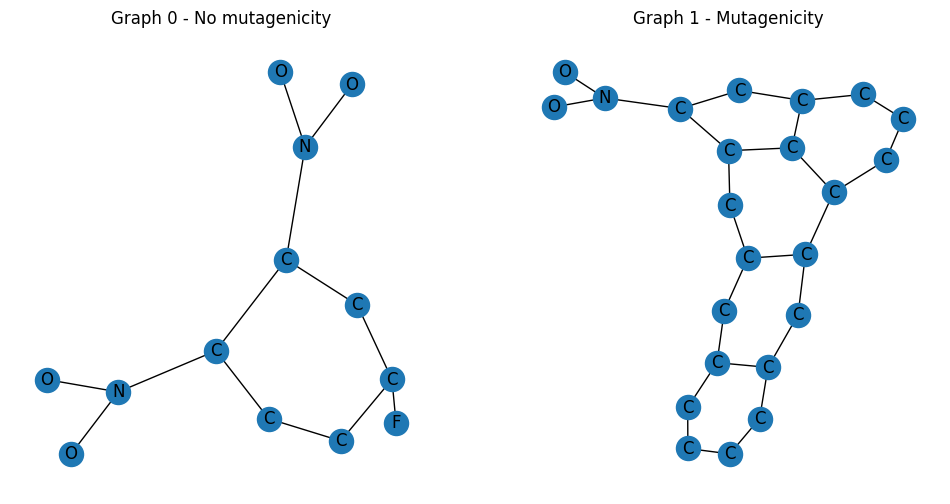

In [ ]:
dataset = dataset.shuffle()
graph_0 = (graph for graph in dataset if graph.y.item() == 0).__next__()
graph_1 = (graph for graph in dataset if graph.y.item() == 1).__next__()
atom_types = ["C", "N", "O", "F", "I", "Cl", "Br"]

node_labels_ori = {i: atom_types[x.argmax().item()] for i, x in enumerate(graph_0.x)}
node_labels = {i: atom_types[x.argmax().item()] for i, x in enumerate(graph_1.x)}
def layout(G):
    return nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Graph 0 - No mutagenicity")
G_0 = to_networkx(graph_0, to_undirected=True)
pos = layout(G_0)  
nx.draw(G_0, labels=node_labels_ori, with_labels=True)

plt.subplot(122)
plt.title("Graph 1 - Mutagenicity")
G_1 = to_networkx(graph_1, to_undirected=True)
nx.draw(G_1, labels = node_labels, with_labels=True)
plt.show()